In [25]:
import tensorflow as tf
import keras as K
import myutils 
import os
%load_ext autoreload
%reload_ext autoreload
%autoreload 2 


# layers = [1, 2, 3]
SubjectFlags = [True, False]
MAX_TEXT_LENS = [1000, 2000, 4000]
embedding_size = 50

SubjectFlag = SubjectFlags[0]
MAX_TEXT_LEN = MAX_TEXT_LENS[1]
INPUT_LEN = MAX_TEXT_LEN + 100 + (2 if SubjectFlag else 0)
             

Strides = [2]
Kernels = [4]
Units = [256]

Filters = {}
Filters[0] = [32, 128]
Filters[1] = [64]
Filters[2] = [32]

BatchSizes = [128]
LearningRates = [1e-3]

ModelsNames = ['Balanced', 'UnbalancedReal', 'UnbalancedFake']

TrainKerasModels = {}
TrainOurModels = {}
for kind in ModelsNames:
    TrainOurModels[kind] = False
    TrainKerasModels[kind] = False
    if not os.path.exists(f'./ourModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}.h5'):
        TrainOurModels[kind] = True        
    if not os.path.exists(f'./ktModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}'):
        TrainKerasModels[kind] = True
    
    
# Remove comment if want to train a model from scratch
TrainKerasModels['Balanced'] = False
TrainKerasModels['UnbalancedReal'] = False
TrainKerasModels['UnbalancedFake'] = False
TrainOurModels['Balanced'] = True
TrainOurModels['UnbalancedReal'] = True
TrainOurModels['UnbalancedFake'] = True
# Check the models that will be trained
allNews = myutils.initDF()

print(TrainOurModels)
print(TrainKerasModels)
tf.config.list_logical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading data from processed file
{'Balanced': False, 'UnbalancedReal': False, 'UnbalancedFake': False}
{'Balanced': False, 'UnbalancedReal': False, 'UnbalancedFake': False}


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Create balanced dataset and create train, validation and test sets

In [26]:
from sklearn.model_selection import train_test_split 
# Pop the label column
balancedLabels = allNews.pop('label')

x_train = {}
y_train = {}
x_val = {}

# Split the data into train, test, and validation sets
x_train["Balanced"], x_test, y_train["Balanced"], y_test = train_test_split(allNews, balancedLabels, test_size=0.1, train_size=0.9, shuffle=False)
x_train["Balanced"], tmp_val, y_train["Balanced"], y_val = train_test_split(x_train["Balanced"], y_train["Balanced"], test_size=0.2222, train_size=0.7778, shuffle=False)
# Check how many samples of each kind we have in the training set
print("Balanced", '\n', y_train["Balanced"].value_counts())

Balanced 
 1    16440
0    14989
Name: label, dtype: int64


## Create unbalanced dataset and create train, validation and test sets
### Only half fake news

In [27]:
# FakeNews label = 1
x_train['UnbalancedFake'], y_train['UnbalancedFake'] = myutils.unbalance(x_train['Balanced'].copy(), y_train['Balanced'].copy(), 1, force=True)
print('UnbalancedFake', '\n', y_train['UnbalancedFake'].value_counts())

UnbalancedFake 
 0    14989
1     8220
Name: label, dtype: int64


### Only half real news

In [28]:
# RealNews label = 0
x_train['UnbalancedReal'], y_train['UnbalancedReal'] = myutils.unbalance(x_train['Balanced'].copy(), y_train['Balanced'].copy(), 0, force=True)
print('UnbalancedReal\n', y_train['UnbalancedReal'].value_counts())

UnbalancedReal
 1    16440
0     7495
Name: label, dtype: int64


## Dict Index

In [29]:
from keras.preprocessing.text import Tokenizer

vectorizer = {}
vocab_size = {}

for kind in ModelsNames:
    # Create a vectorizer for each dataset
    vectorizer[kind] = Tokenizer(num_words=10000)
    
    # Fit the vectorizer to the data in each dataset8
    vectorizer[kind].fit_on_texts(x_train[kind].title)
    vectorizer[kind].fit_on_texts(x_train[kind].text)
    vectorizer[kind].fit_on_texts(x_train[kind].subject)
    
    # Save the vocab size for each dataset
    vocab_size[kind] = len(vectorizer[kind].word_index) + 2

### Text conversion

In [30]:

from keras_preprocessing.sequence import pad_sequences

def convert(df, kind, columns = ['title', 'text', 'subject']):
    for column in columns:
        df[column] = vectorizer[kind].texts_to_sequences(df[column])
    return df

# Convert the data in each dataset
for kind in ModelsNames:
    x_train[kind] = convert(x_train[kind].copy(), kind)
    # Convert validation set
    # Validation set is equal for all the tests
    x_val[kind] = convert(tmp_val.copy(), kind)

In [31]:
for kind in ModelsNames:
    print(kind, x_train[kind].shape)

Balanced (31429, 4)
UnbalancedReal (23935, 4)
UnbalancedFake (23209, 4)


### Text Padding/Truncation for Normalization

In [32]:
import numpy as np


def Normalize(df, columns = ['title', 'text'], subject = True, MAX_LEN = MAX_TEXT_LEN, PaddingKind = 'post'):
    tmp = {}    
    for column in columns:
        tmp[column] = pad_sequences(df[column].tolist(), maxlen=(MAX_LEN if column == 'text' else 100), padding=PaddingKind)
    if subject:
        tmp['subject'] = pad_sequences(df['subject'].tolist(), maxlen=2, padding=PaddingKind)
    out = np.empty((len(tmp['text']), INPUT_LEN))
    for i in range(len(tmp['text'])):
        if subject:
            out[i] = np.append(np.append(tmp['text'][i], tmp['title'][i]), tmp['subject'][i])
        else:
            out[i] = np.append(tmp['text'][i], tmp['title'][i])
    return out

# Pad the data in training for each dataset
for kind in ModelsNames:
    # if not TrainModels[kind]:
    #     continue
    x_train[kind] = Normalize(x_train[kind].copy(), subject=SubjectFlag)
    # Convert to numpy arrays the labels for Balanced training dataset
    y_train[kind] = np.array(y_train[kind])
    # Pad the data in Validation training dataset
    x_val[kind] = Normalize(x_val[kind].copy(), subject=SubjectFlag)
    
# Convert to numpy arrays the labels for Validation set
y_val = np.array(y_val)

# Print shape of data and label for each Training Set
for kind in ModelsNames:
    print('Shape of data for ' + kind + ' training set:', x_train[kind].shape)
    print('Shape of label for ' + kind + ' training set:', y_train[kind].shape)
    print('Shape of data for ' + kind + ' Validation set:', x_val[kind].shape)
    print('Shape of label for Validation set:', y_val.shape)

Shape of data for Balanced training set: (31429, 2102)
Shape of label for Balanced training set: (31429,)
Shape of data for Balanced Validation set: (8979, 2102)
Shape of label for Validation set: (8979,)
Shape of data for UnbalancedReal training set: (23935, 2102)
Shape of label for UnbalancedReal training set: (23935,)
Shape of data for UnbalancedReal Validation set: (8979, 2102)
Shape of label for Validation set: (8979,)
Shape of data for UnbalancedFake training set: (23209, 2102)
Shape of label for UnbalancedFake training set: (23209,)
Shape of data for UnbalancedFake Validation set: (8979, 2102)
Shape of label for Validation set: (8979,)


In [33]:
for kind in ModelsNames:
    print(kind, x_train[kind].shape, x_train[kind])

Balanced (31429, 2102) [[2.600e+01 1.100e+01 1.000e+00 ... 0.000e+00 1.600e+02 5.500e+01]
 [1.100e+02 8.730e+02 6.170e+02 ... 0.000e+00 1.600e+02 5.500e+01]
 [1.070e+02 7.100e+01 7.000e+01 ... 0.000e+00 1.930e+02 0.000e+00]
 ...
 [7.100e+01 2.731e+03 2.900e+01 ... 0.000e+00 1.930e+02 0.000e+00]
 [1.200e+01 2.100e+01 1.000e+00 ... 0.000e+00 2.030e+02 0.000e+00]
 [1.305e+03 9.100e+01 1.130e+02 ... 0.000e+00 2.030e+02 0.000e+00]]
UnbalancedReal (23935, 2102) [[2.100e+01 1.000e+01 1.000e+00 ... 0.000e+00 1.420e+02 4.300e+01]
 [1.100e+02 7.520e+02 5.320e+02 ... 0.000e+00 1.420e+02 4.300e+01]
 [1.340e+02 1.090e+02 1.000e+00 ... 0.000e+00 2.910e+02 0.000e+00]
 ...
 [1.090e+02 3.080e+02 2.300e+01 ... 0.000e+00 3.490e+02 0.000e+00]
 [1.200e+01 2.300e+01 1.000e+00 ... 0.000e+00 1.720e+02 0.000e+00]
 [1.392e+03 7.700e+01 1.130e+02 ... 0.000e+00 1.720e+02 0.000e+00]]
UnbalancedFake (23209, 2102) [[9.500e+01 4.800e+01 6.000e+01 ... 0.000e+00 1.310e+02 0.000e+00]
 [9.500e+01 4.800e+01 1.000e+00 ... 

## Embedding

In [34]:
import numpy as np
embedding_dict = {}
with open(f"./embeddings/glove.6B.{embedding_size}d.txt") as f:
    for line in f:
        words, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embedding_dict[words] = coefficients

### Embedding Matrix

In [35]:
import numpy as np
embedding_dim = embedding_size

embedding_matrix = {}

for kind in ModelsNames:
    embedding_matrix[kind] = np.zeros((vocab_size[kind], embedding_dim))
    for word, i in vectorizer[kind].word_index.items():
        embedding_vector = vectorizer[kind].word_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[kind][i] = embedding_vector
    # Print all embedding matrix shapes
    print(kind, embedding_matrix[kind].shape)

Balanced (126648, 100)
UnbalancedReal (112853, 100)
UnbalancedFake (106905, 100)


# Tensorflow embedding layer

In [36]:
embedding_layer = {}
for kind in ModelsNames:
    embedding_layer[kind] = K.layers.Embedding(vocab_size[kind], embedding_dim, embeddings_initializer= K.initializers.Constant(embedding_matrix[kind]), trainable=False, input_length=INPUT_LEN)
        
GLOBAL_KIND = 'Balanced'
def getEmbeddingLayer(kind):
    return embedding_layer[kind]

In [37]:
for kind in ModelsNames:
    print(kind, x_train[kind].shape,  y_train[kind].shape)
    print(kind, x_val[kind].shape, y_val.shape)

Balanced (31429, 2102) (31429,)
Balanced (8979, 2102) (8979,)
UnbalancedReal (23935, 2102) (23935,)
UnbalancedReal (8979, 2102) (8979,)
UnbalancedFake (23209, 2102) (23209,)
UnbalancedFake (8979, 2102) (8979,)


# Test data conversion 

In [38]:
import numpy as np
xt = {}
for kind in ModelsNames:
    xt[kind] = convert(x_test.copy(), kind)
    xt[kind] = Normalize(xt[kind], subject=SubjectFlag)
    xt[kind].shape
y_test = np.array(y_test)

# Tensorflow CNN model

In [39]:
import visualkeras
import pickle
ourParamModels = {}
ourmodel_hist = {}

for kind in ModelsNames:
    if TrainOurModels[kind]:    
        ourParamModels[kind] = K.Sequential()
        ourParamModels[kind].add(embedding_layer[kind])
        ourParamModels[kind].add(K.layers.Conv1D(128, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(64, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Conv1D(32, 4, padding='same', activation='relu'))
        ourParamModels[kind].add(K.layers.MaxPooling1D(2))
        ourParamModels[kind].add(K.layers.Flatten())
        ourParamModels[kind].add(K.layers.Dense(256, activation='relu'))
        ourParamModels[kind].add(K.layers.Dense(1, activation='sigmoid'))
        
        ourParamModels[kind].compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        
        ourmodel_hist[kind] = ourParamModels[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                                                mode='min',
                                                                                                patience=3,
                                                                                                min_delta=0.003,
                                                                                                restore_best_weights=True)])
        ourParamModels[kind].save(f'./ourModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}.h5')
        with open(f'./ourModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}_hist.hist', 'wb') as file_pi:
            pickle.dump(ourmodel_hist[kind].history, file_pi)
    else:
        ourParamModels[kind] = tf.keras.models.load_model(f'./ourModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}.h5')
        with open(f'./ourModels/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}_hist.hist', 'rb') as file_pi:
            ourmodel_hist[kind] = pickle.load(file_pi)
        
    visualkeras.layered_view(ourParamModels[kind], scale_xy=0.8, draw_volume=True, legend=True, to_file=f'./Models/{kind}_{str(MAX_TEXT_LEN)}_{str(SubjectFlag)}.png')

## Accuracy on Train and Validation set for each one of our models

In [40]:
from sklearn import metrics
for kind in ModelsNames:
    print('Our Param: Accuracy train set ', kind, metrics.accuracy_score(y_train[kind], ourParamModels[kind].predict(x_train[kind]) >= 0.5 ))
    print('Our Param: Accuracy validation set ', kind, metrics.accuracy_score(y_val, ourParamModels[kind].predict(x_val[kind]) >= 0.5 ))
    print('\n')

983/983 [==============================] - 10s 10ms/step
Our Param: Accuracy train set  Balanced 0.9043558496929587
281/281 [==============================] - 3s 10ms/step
Our Param: Accuracy validation set  Balanced 0.892415636485132


748/748 [==============================] - 7s 10ms/step
Our Param: Accuracy train set  UnbalancedReal 0.9988301650302903
281/281 [==============================] - 3s 10ms/step
Our Param: Accuracy validation set  UnbalancedReal 0.9984408063258715


726/726 [==============================] - 7s 10ms/step
Our Param: Accuracy train set  UnbalancedFake 0.9990951785945108
281/281 [==============================] - 3s 10ms/step
Our Param: Accuracy validation set  UnbalancedFake 0.9972157255819134




## Our Model Training History

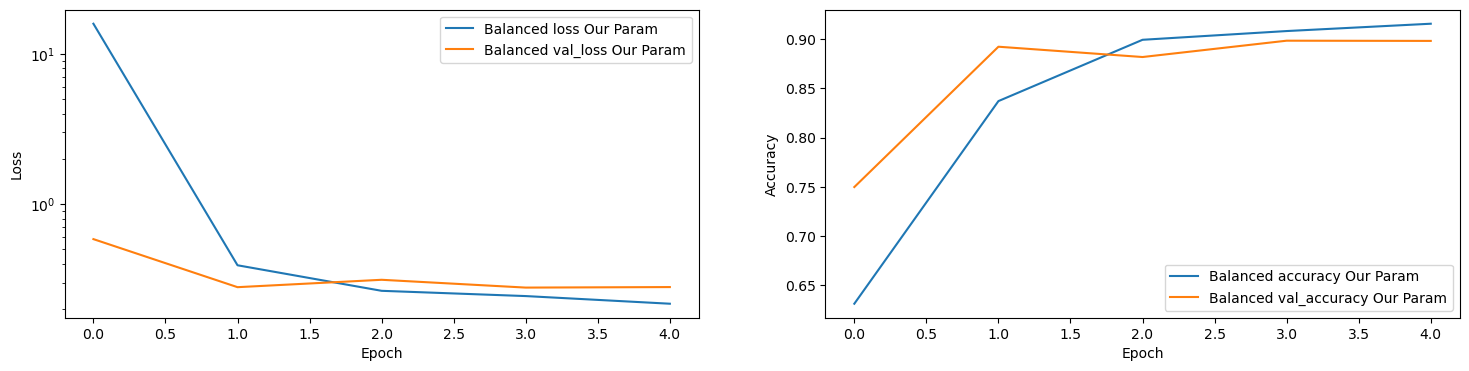

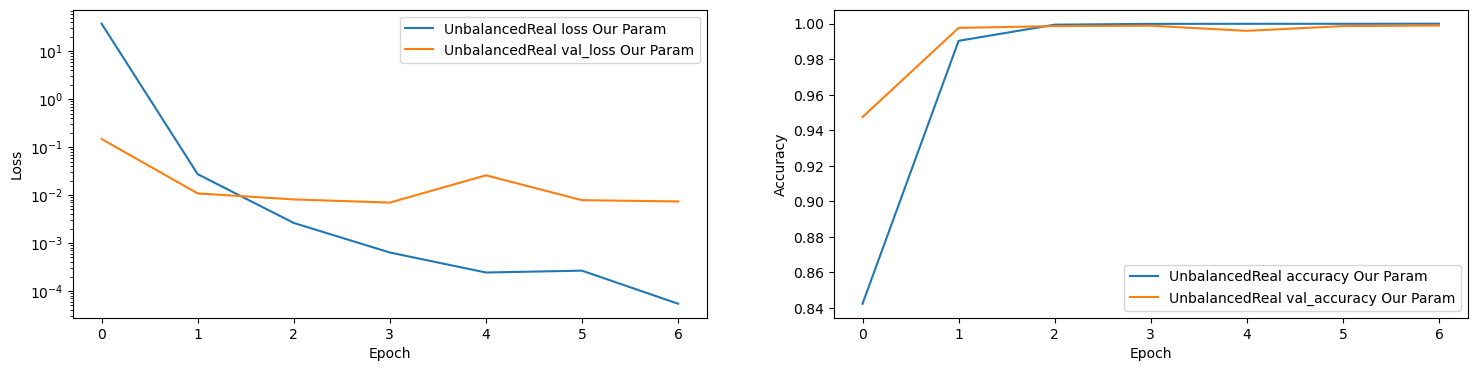

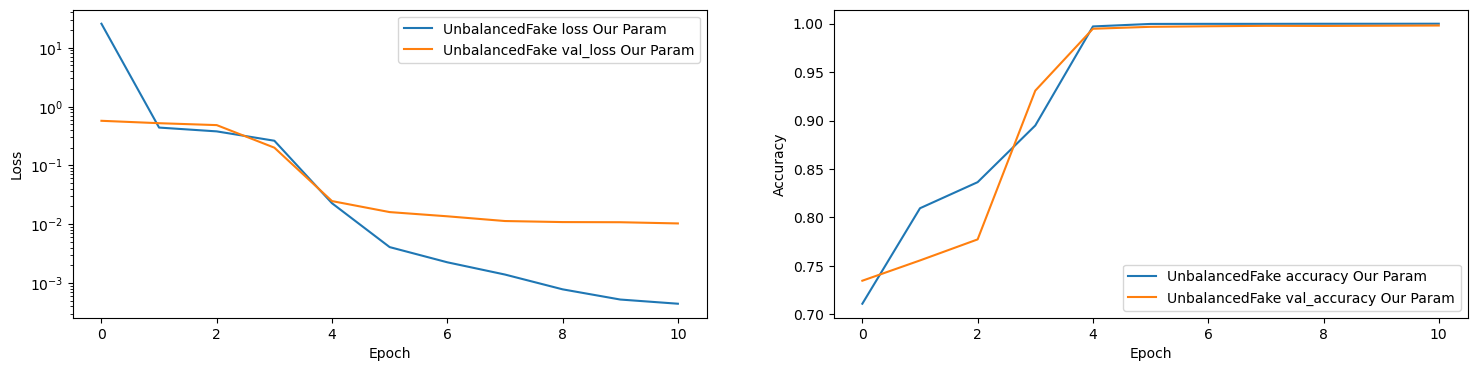

In [42]:
import matplotlib.pyplot as plt
for i, kind in enumerate(ModelsNames):
    # plot training history
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    # ax[i].set_title(knd + ' training history')
    ax[0].plot(ourmodel_hist[kind]['loss'], label= kind + ' loss Our Param')
    ax[0].plot(ourmodel_hist[kind]['val_loss'], label = kind + ' val_loss Our Param')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    ax[0].legend(loc='upper right');
    
    ax[1].plot(ourmodel_hist[kind]['accuracy'], label=kind + ' accuracy Our Param')
    ax[1].plot(ourmodel_hist[kind]['val_accuracy'], label = kind + ' val_accuracy Our Param')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='lower right');

## Our Models Test confusion matrices

141/141 [==============================] - 1s 10ms/step


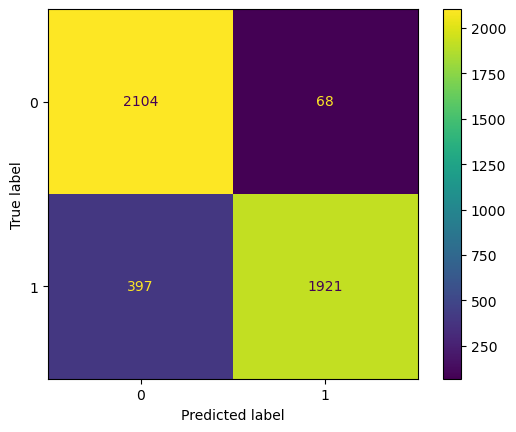

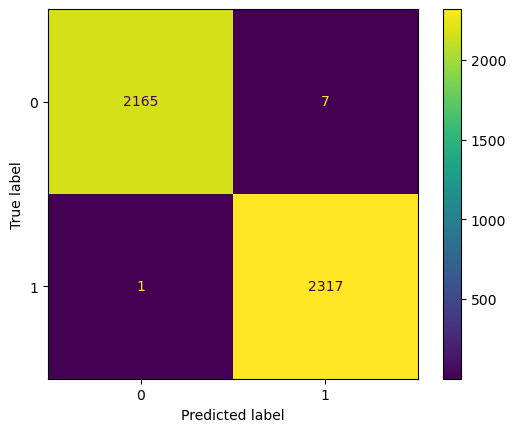

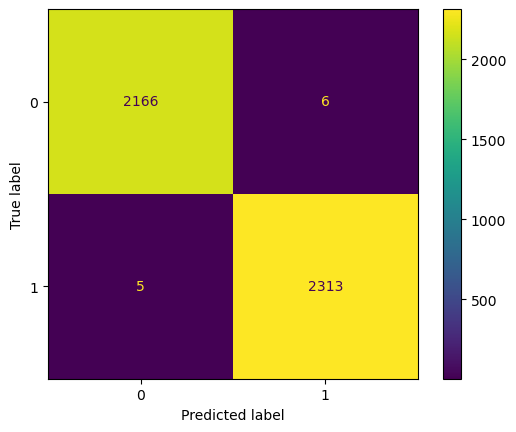

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predict = {}
cm = {}
disp = {}
for kind in ModelsNames:
    test_predict[kind] = (ourParamModels[kind].predict(xt[kind]) >= 0.5).astype('bool')
    cm = confusion_matrix(y_test, test_predict[kind])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

## Our Models metrics on test set

In [ ]:
for kind in ModelsNames:
    print(kind + ' Accuracy test set ', metrics.accuracy_score(y_test, test_predict[kind]))
    print(kind + ' Precision test set ', metrics.precision_score(y_test, test_predict[kind]))
    print(kind + ' Recall test set ', metrics.recall_score(y_test, test_predict[kind]))
    print(kind + ' F1 score test set ', metrics.f1_score(y_test, test_predict[kind]))
    print('\n')

Balanced Accuracy test set  0.5305122494432071
Balanced Precision test set  0.5412411626080126
Balanced Recall test set  0.5944779982743744
Balanced F1 score test set  0.5666118421052633


UnbalancedReal Accuracy test set  0.49933184855233853
UnbalancedReal Precision test set  0.5295109612141653
UnbalancedReal Recall test set  0.27092320966350303
UnbalancedReal F1 score test set  0.3584474885844749


UnbalancedFake Accuracy test set  0.4708240534521158
UnbalancedFake Precision test set  0.48013698630136986
UnbalancedFake Recall test set  0.30241587575496115
UnbalancedFake F1 score test set  0.3710958178930651




# Keras Tuner for Hyperparameter Tuning (Optional)

In [19]:
import keras_tuner
models = {}
model_hist = {}

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = K.Sequential()
        model.add(getEmbeddingLayer(GLOBAL_KIND))
        model.add(K.layers.Conv1D(hp.Choice('conv_1_filters', Filters[0]), 
                                hp.Choice('conv_1_kernel', Kernels), 
                                padding='same', activation='relu'))
        model.add(K.layers.MaxPooling1D(hp.Choice('conv_1_strides', Strides)))
        model.add(K.layers.Conv1D(hp.Choice('conv_2_filters', Filters[1]), 
                                hp.Choice('conv_2_kernel', Kernels), 
                                padding='same', activation='relu'))
        model.add(K.layers.MaxPooling1D(hp.Choice('conv_2_strides', Strides)))
        model.add(K.layers.Conv1D(hp.Choice('conv_3_filters', Filters[2]), 
                                hp.Choice('conv_3_kernel', Kernels), 
                                padding='same', activation='relu'))
        model.add(K.layers.MaxPooling1D(hp.Choice('conv_3_strides', Strides)))
        
        model.add(K.layers.Flatten())
        model.add(K.layers.Dense(hp.Choice('dense_1_units', Units), activation='relu'))
        model.add(K.layers.Dense(1, activation='sigmoid'))
        model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(
                    learning_rate = hp.Choice('learning_rate', LearningRates)
                ), 
                loss=K.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )
        return model


    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            **kwargs,
            shuffle=True,
            epochs=15,
            batch_size=hp.Choice("batch_size",  BatchSizes),
            verbose=1,
            workers=-1,
            use_multiprocessing=True
            )

tuner = {}
for kind in ModelsNames:  
    # Finding best hyperparameters for each model
    print("Finding best hyperparameters for ", kind)
    GLOBAL_KIND = kind
    tuner[kind] = keras_tuner.GridSearch(
        MyHyperModel(),
        objective="val_accuracy",
        overwrite=TrainKerasModels[kind],
        directory="./ktModels/" + kind + '_' + str(MAX_TEXT_LEN) + '_' + str(SubjectFlag),
        project_name=kind + "_CNN",
    )

    # if TrainModels[kind]:
    tuner[kind].search(x_train[kind], y_train[kind], 
                    validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=3,
                            min_delta=0.05,
                            restore_best_weights=True)])
    print(kind, tuner[kind].get_best_hyperparameters()[0].values)
    models[kind] = tuner[kind].hypermodel.build(tuner[kind].get_best_hyperparameters()[0])
    if TrainKerasModels[kind]:
        model_hist[kind] = models[kind].fit(x_train[kind], y_train[kind], batch_size=128, 
                                    epochs=15, validation_data=(x_val[kind], y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
        mode='min',
        patience=3,
        min_delta=0.05,
        restore_best_weights=True)])
        models[kind].save('./ktModels/' + kind + '_' + str(MAX_TEXT_LEN) + '_' + str(SubjectFlag))

Finding best hyperparameters for  Balanced
INFO:tensorflow:Reloading Tuner from ../ktModels/Balanced_2000_True/Balanced_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
Balanced {'conv_1_filters': 32, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Finding best hyperparameters for  UnbalancedReal
INFO:tensorflow:Reloading Tuner from ../ktModels/UnbalancedReal_2000_True/UnbalancedReal_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit
UnbalancedReal {'conv_1_filters': 128, 'conv_1_kernel': 4, 'conv_1_strides': 2, 'conv_2_filters': 64, 'conv_2_kernel': 4, 'conv_2_strides': 2, 'conv_3_filters': 32, 'conv_3_kernel': 4, 'conv_3_strides': 2, 'dense_1_units': 256, 'learning_rate': 0.001, 'batch_size': 128}
Finding best hyperparameters for  UnbalancedFake
INFO:tensorflow:Reloading Tuner from ../ktModels/U

## Accuracy on Train and Validation set for each one of Keras Tuner models

In [20]:
for kind in ModelsNames:
    print('Keras Tuner: Accuracy train set ', kind, metrics.accuracy_score(y_train[kind], models[kind].predict(x_train[kind]) >= 0.5 ))
    print('Keras Tuner: Accuracy validation set ', kind, metrics.accuracy_score(y_val, models[kind].predict(x_val[kind]) >= 0.5 ))
    print('\n')

983/983 [==============================] - 8s 8ms/step
Keras Tuner: Accuracy train set  Balanced 0.5296382322059244
281/281 [==============================] - 2s 8ms/step
Keras Tuner: Accuracy validation set  Balanced 0.5334669785054015


748/748 [==============================] - 7s 10ms/step
Keras Tuner: Accuracy train set  UnbalancedReal 0.42072279089199915
281/281 [==============================] - 3s 10ms/step
Keras Tuner: Accuracy validation set  UnbalancedReal 0.4952667334892527


726/726 [==============================] - 7s 10ms/step
Keras Tuner: Accuracy train set  UnbalancedFake 0.526045930458012
281/281 [==============================] - 3s 10ms/step
Keras Tuner: Accuracy validation set  UnbalancedFake 0.46876044102906783




## Keras Tuner Models Training History

In [21]:
# for i, kind in enumerate(ModelsNames):
#     # plot training history
#     fig, ax = plt.subplots(1, 2, figsize=(18, 4))
#     # ax[i].set_title(knd + ' training history')
#     ax[0].plot(model_hist[kind].history['loss'], label= kind + ' loss Keras')
#     ax[0].plot(model_hist[kind].history['val_loss'], label = kind + ' val_loss Keras')
#     ax[0].set_xlabel('Epoch')
#     ax[0].set_ylabel('Loss')
#     ax[0].set_yscale('log')
#     ax[0].legend(loc='upper right');
    
#     ax[1].plot(model_hist[kind].history['accuracy'], label=kind + ' accuracy Keras')
#     ax[1].plot(model_hist[kind].history['val_accuracy'], label = kind + ' val_accuracy Keras')
#     ax[1].set_xlabel('Epoch')
#     ax[1].set_xlabel('Epoch')
#     ax[1].set_ylabel('Accuracy')
#     ax[1].legend(loc='lower right');

## Keras Tuner Models Test confusion matrices

141/141 [==============================] - 1s 10ms/step


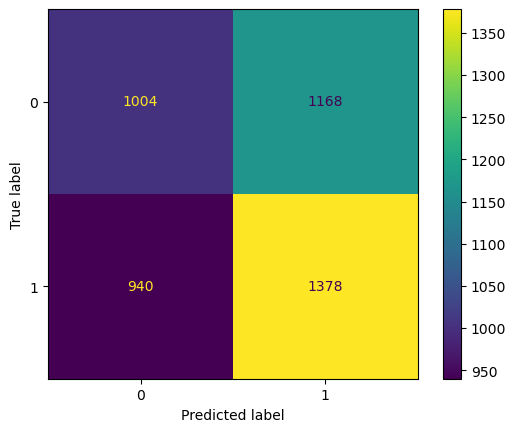

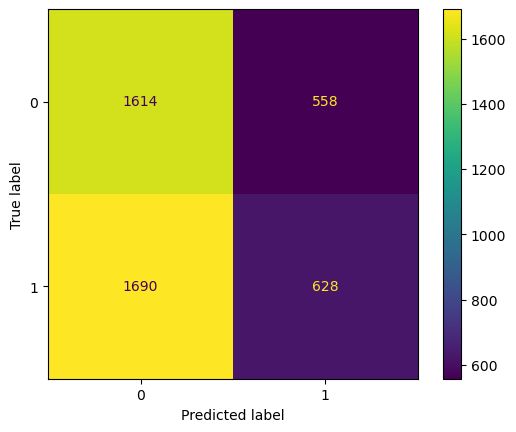

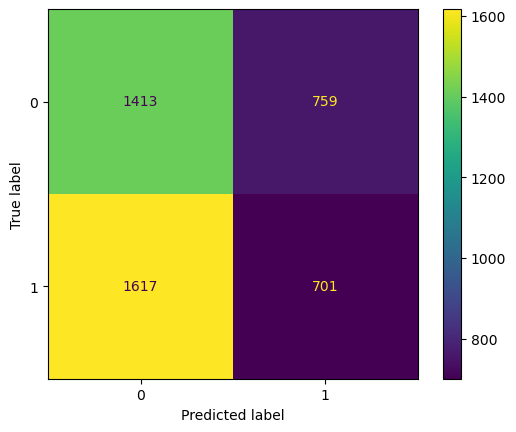

In [22]:
test_predict = {}
cm = {}
disp = {}
for kind in ModelsNames:
    test_predict[kind] = (models[kind].predict(xt[kind]) >= 0.5).astype('bool')
    cm = confusion_matrix(y_test, test_predict[kind])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

## Keras Tuner Models metrics on test set

In [23]:
for kind in ModelsNames:
    print(kind + ' Accuracy test set ', metrics.accuracy_score(y_test, test_predict[kind]))
    print(kind + ' Precision test set ', metrics.precision_score(y_test, test_predict[kind]))
    print(kind + ' Recall test set ', metrics.recall_score(y_test, test_predict[kind]))
    print(kind + ' F1 score test set ', metrics.f1_score(y_test, test_predict[kind]))
    print('\n')

Balanced Accuracy test set  0.5305122494432071
Balanced Precision test set  0.5412411626080126
Balanced Recall test set  0.5944779982743744
Balanced F1 score test set  0.5666118421052633


UnbalancedReal Accuracy test set  0.49933184855233853
UnbalancedReal Precision test set  0.5295109612141653
UnbalancedReal Recall test set  0.27092320966350303
UnbalancedReal F1 score test set  0.3584474885844749


UnbalancedFake Accuracy test set  0.4708240534521158
UnbalancedFake Precision test set  0.48013698630136986
UnbalancedFake Recall test set  0.30241587575496115
UnbalancedFake F1 score test set  0.3710958178930651


